# **MEMBUAT MODEL TIME SERIES UNTUK MENGUKUR KEKUATAN GEMPA**

**IMPORT LIBRARY**

In [44]:
# Library Visualisasi dan pengolahan data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Library uji stasioner
from statsmodels.tsa.stattools import adfuller

# Library analisis ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Library Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
df = pd.read_csv("katalog_gempa.csv")

df

,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
0,2008/11/01,21:02:43.058,-9.18,119.06,10,4.9,Sumba Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
1,2008/11/01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN
2,2008/11/01,17:43:12.941,-7.01,106.63,121,3.7,Java - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
3,2008/11/01,16:24:14.755,-3.30,127.85,10,3.2,Seram - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
4,2008/11/01,16:20:37.327,-6.41,129.54,70,4.3,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92882,2023/01/26,02:25:09.288,3.24,127.18,10,4.0,Talaud Islands - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
92883,2023/01/26,02:15:03.893,2.70,127.10,10,3.9,Northern Molucca Sea,NaN,NaN,NaN,NaN,NaN,NaN
92884,2023/01/26,01:57:08.885,-7.83,121.07,10,3.8,Flores Sea,NaN,NaN,NaN,NaN,NaN,NaN
92885,2023/01/26,01:46:21.009,3.00,127.16,10,4.1,Northern Molucca Sea,NaN,NaN,NaN,NaN,NaN,NaN


# **# DATA UNDERSTANDING**

Data Understanding (pemahaman data) adalah tahap dalam proses analisis data yang melibatkan eksplorasi dan pemahaman karakteristik data yang ada.



*   Sumber Data ( https://www.kaggle.com/datasets/kekavigi/earthquakes-in-indonesia )



 **FITUR PADA DATA**



Informasi Kolom :
*  tgl    : tanggal kejadian
*  ot     : stempel waktu acara
*  lat    : garis lintang episentrum peristiwa (derajat), mulai dari 6N hingga 11S
*  lon    : garis bujur pusat gempa (derajat), mulai dari 142E hingga 94E
*  depth  : kedalaman kejadian (km)
*  mag    : besarnya peristiwa, mulai dari 1 hingga 9,5
*  remark : Flinn-Engdahl wilayah acara
terkadang, mekanisme fokus acara diukur. Dalam hal ini, nilai dip1, strike1, rake1, dip2, strike2, dan rake2 tidak kosong.



In [46]:
# Mengetahui jumlah kolom pada dataset
df.shape

(92887, 13)

In [47]:
# Mengetahui informasi tipe data masing-masing kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tgl      92887 non-null  object 
 1   ot       92887 non-null  object 
 2   lat      92887 non-null  float64
 3   lon      92887 non-null  float64
 4   depth    92887 non-null  int64  
 5   mag      92887 non-null  float64
 6   remark   92887 non-null  object 
 7   strike1  2735 non-null   float64
 8   dip1     2735 non-null   float64
 9   rake1    2735 non-null   float64
 10  strike2  2735 non-null   float64
 11  dip2     2735 non-null   float64
 12  rake2    2735 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 9.2+ MB


In [48]:
# Mengetahui informasi statistik pada dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,92887.0,-3.404577,4.354584,-11.00,-7.885,-2.91,0.14,6.00
lon,92887.0,119.159707,10.833202,94.02,113.170,121.16,126.90,142.00
depth,92887.0,49.009399,76.761070,2.00,10.000,16.00,54.00,750.00
mag,92887.0,3.592788,0.834042,1.00,3.000,3.50,4.20,7.90
strike1,2735.0,170.142852,88.359267,0.00,107.550,144.60,217.50,359.20
dip1,2735.0,60.202121,19.699252,2.30,46.950,62.30,76.40,90.00
rake1,2735.0,30.358062,99.957906,-180.00,-28.500,57.60,100.15,180.00
strike2,2735.0,197.450303,118.920519,0.00,63.115,240.72,297.48,359.98
dip2,2735.0,56.576344,21.274923,1.50,39.400,58.40,74.70,90.00
rake2,2735.0,35.250018,98.235894,-180.00,-19.900,56.50,112.60,180.00


In [49]:
# Mengetahui nilai null pada dataset
df.isnull().sum()

tgl            0
ot             0
lat            0
lon            0
depth          0
mag            0
remark         0
strike1    90152
dip1       90152
rake1      90152
strike2    90152
dip2       90152
rake2      90152
dtype: int64

# **# EDA  (Exploratory Data Analysis)**
EDA (Exploratory Data Analysis) adalah proses analisis data yang bertujuan untuk memahami karakteristik data, mengidentifikasi pola, dan menemukan insight yang berguna untuk pengambilan keputusan

> **Visualisasi Line Plot**

> Disini kami menampilkan hubungan antara Tanggal dan Magnitudo untuk melihat karakteristik hubungan Tanggal dan Magnitudo.

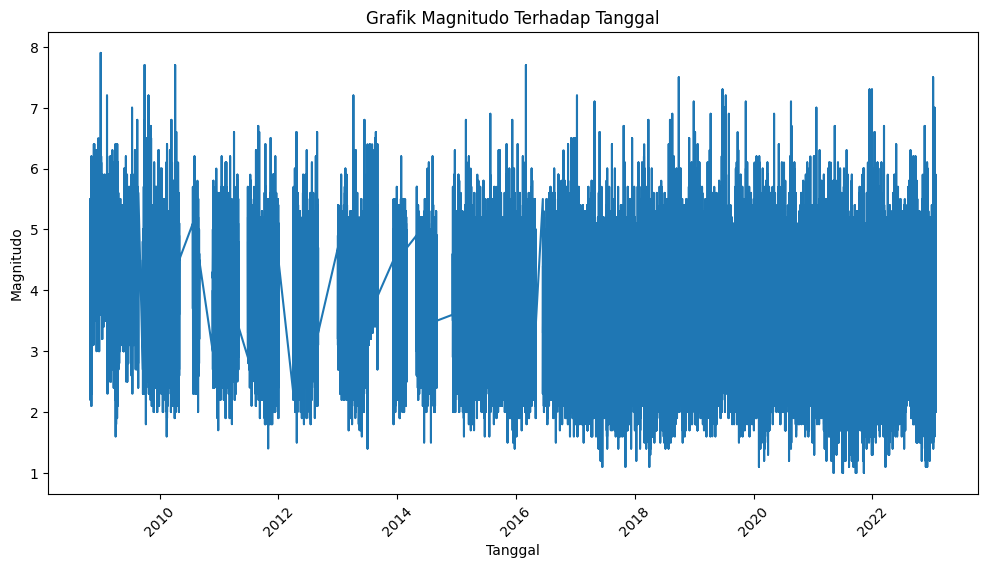

In [50]:
df['tgl'] = pd.to_datetime(df['tgl'])
# Visualisasi data dengan line plot
plt.figure(figsize=(12, 6))
plt.plot(df['tgl'], df['mag'])
plt.xlabel('Tanggal')
plt.ylabel('Magnitudo')
plt.title('Grafik Magnitudo Terhadap Tanggal')
plt.xticks(rotation=45)
plt.show()

> **Analisis Trend**

> Kami melakukan analisis trend untuk melihat pola atau kecenderungan kekuatan gempa seiring berjalannya waktu untuk memahami peningkatan atau penurunan magnitudo gempa setiap waktunya.

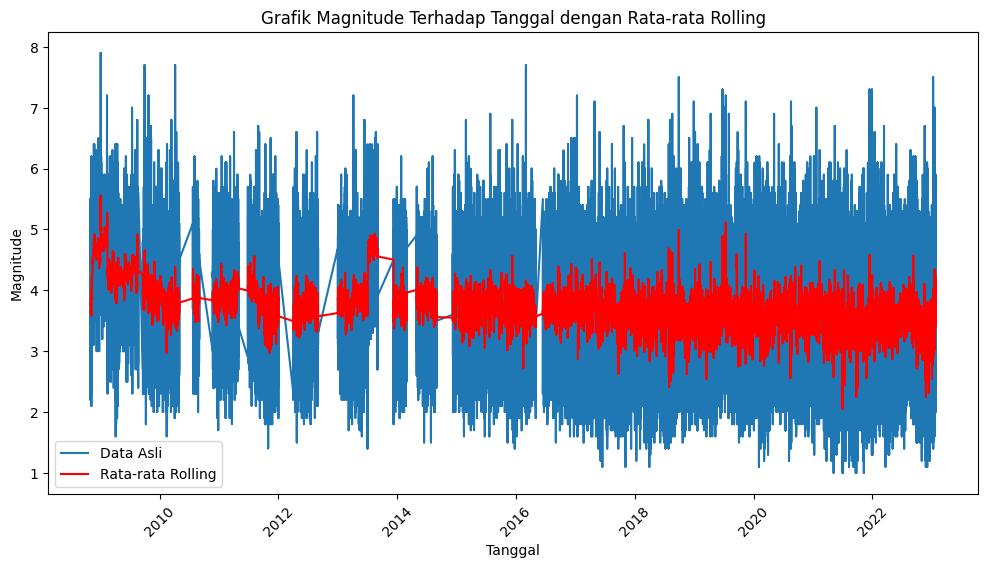

In [51]:
# Pada analisis trend ini kami menggunakan metode rolling mean sehingga hasil tren menjali lebih halus
window = 30  # Disini jumlah jendela perhitungan rata-rata 30 sama seperti jumlah hari
rolling_mean = df['mag'].rolling(window).mean()

# Visualisasi tren dengan line plot
plt.figure(figsize=(12, 6))
plt.plot(df['tgl'], df['mag'], label='Data Asli')
plt.plot(df['tgl'], rolling_mean, color='red', label='Rata-rata Rolling')
plt.xlabel('Tanggal')
plt.ylabel('Magnitude')
plt.title('Grafik Magnitude Terhadap Tanggal dengan Rata-rata Rolling')
plt.legend()
plt.xticks(rotation=45)
plt.show()

> **Analisis Fluktuasi**

> Analisis Fluktuasi disini digunakan untuk melihat pola ketidakstabilan kekuatan gempa seiring berjalannya waktu yang nantinya akan sangat berguna untuk melakukan pemodelan

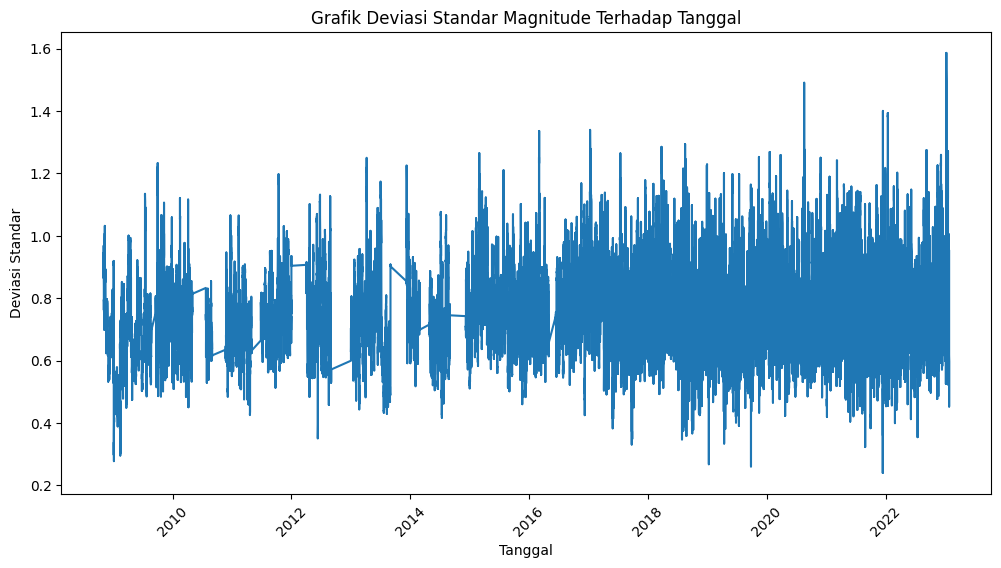

In [52]:
# Dalam proses analisis Fluktuasi ini kami menggunakan metode Rolling Standard Deviation
window = 30  # Jumlah data dalam jendela perhitungan deviasi standar
rolling_std = df['mag'].rolling(window).std()

# Visualisasi fluktuasi dengan line plot
plt.figure(figsize=(12, 6))
plt.plot(df['tgl'], rolling_std)
plt.xlabel('Tanggal')
plt.ylabel('Deviasi Standar')
plt.title('Grafik Deviasi Standar Magnitude Terhadap Tanggal')
plt.xticks(rotation=45)
plt.show()

> **Mengidentifikasi Anomali Data**

> Mengidentifikasi Anomali atau seringkali disebut dengan Outlier data, pada proses Analisis Time Series kali ini kami memilih untuk tidak menghilangkan data Outlier dikarenakan data Outlier merupakan sebuah Anomali yang dapat terjadi yang nantinya akan menjadi data penting untuk proses pemodelan

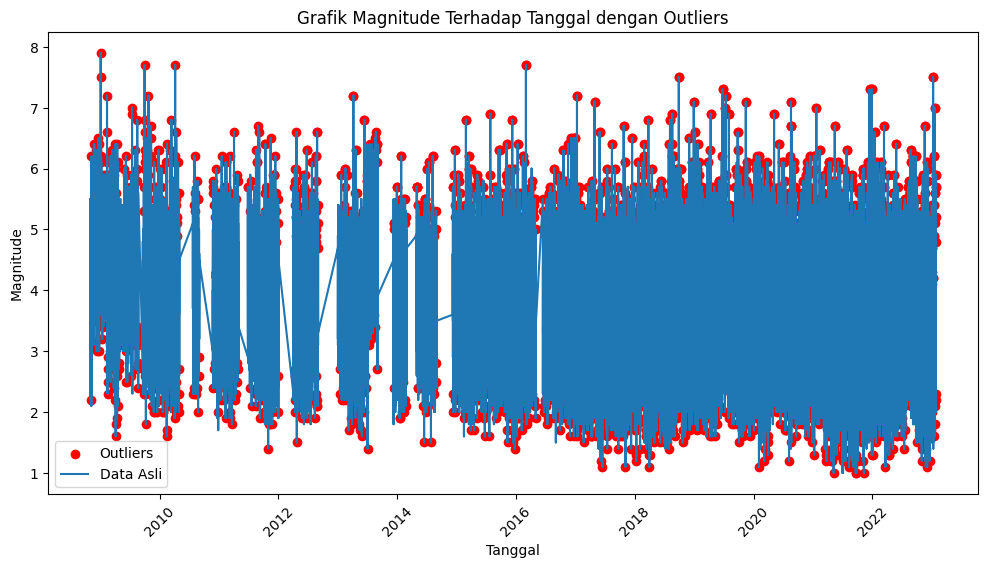

In [53]:
# Mengidentifikasi anomali dalam data berdasarkan perbedaan antara magnitudo dan rolling mean yang dihitung menggunakan standar deviasi.
outliers = df[(df['mag'] > (rolling_mean + 2 * rolling_std)) |
          (df['mag'] < (rolling_mean - 2 * rolling_std))]

# Visualisasi outliers dengan scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(outliers['tgl'], outliers['mag'], color='red', label='Outliers')
plt.plot(df['tgl'], df['mag'], label='Data Asli')
plt.xlabel('Tanggal')
plt.ylabel('Magnitude')
plt.title('Grafik Magnitude Terhadap Tanggal dengan Outliers')
plt.legend()
plt.xticks(rotation=45)
plt.show()

> **Diferencing Data**

> Disini kami menggunakan metode Diferencing data untuk menciptakan deret waktu baru yang berisi selisih waktu sekarang dan sebelumnya, sehingga dapat mengahapus suatu tren pada data untuk menjadikan data lebih stasioner. Mudahnya Diferencing Data adalah proses untuk mengubah data yang tidak stasioner menjadi stasioner sehingga nantinya memudahkan dalam analisis dan juga pemodelan.

In [54]:
# Melakukan diferencing data
data_diff = df['mag'].diff().dropna()

> **Uji Stasioneritas**

> Untuk mengetahui apakah data yang kita punya memiliki perubahan statistiknya setiap waktunya, disini kami melakukan Uji Stasionaritas. Metode yang kami gunakan adalah Augmented Dickey-Fuller (ADF) test.

In [55]:
# Memulai melakukan pengecekan dengan fungsi def_test
def adf_test(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, ':', value)

adf_test(df['mag'])

ADF Statistic: -18.93428068081308
p-value: 0.0
Critical Values:
1% : -3.43042045335977
5% : -2.8615711392546848
10% : -2.5667865743402594


Dari hasil pengujian di atas menghasilkan nilai ADF statistic = -4.745 yang mana ini lebih kecil dari Critical Values 1%, 5% dan 10% sehingga H0 ditolak. sehingga dapat disimpulkan bahwa data deret waktu telah diubah menjadi stasioner dan siap digunakan dalam pemodelan.

> **Analisis ACF dan PACF**

> Kami menggunakan analisis ACF dan PACF untuk memahami pola dalam data yang memiliki deret waktu sehingga kami dapat mengetahui model mana yang sesuai dengan pola yang dimiliki oleh data yang kami punya.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


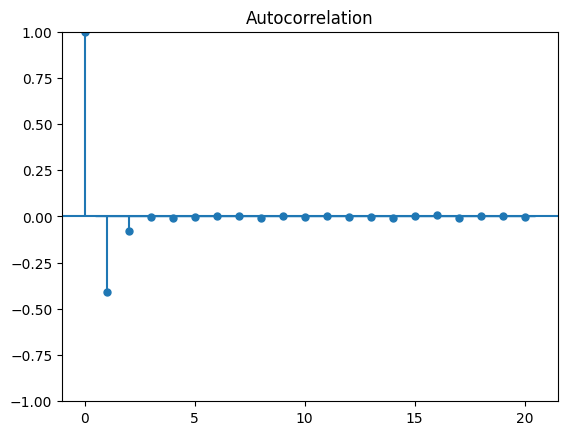

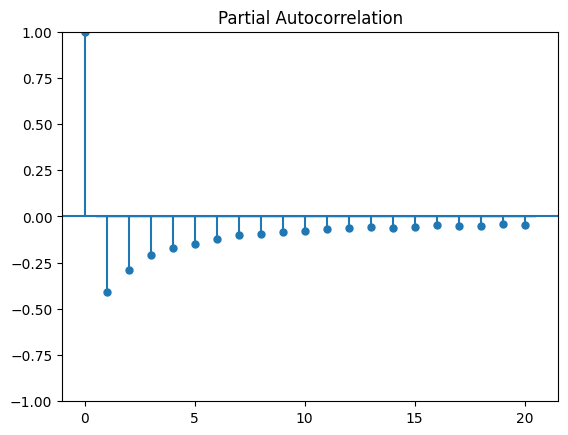

In [56]:
# Analisis ACF dan PACF
plot_acf(data_diff, lags=20)
plot_pacf(data_diff, lags=20)
plt.show()

# **# DATA PREPARATION**

Data Preparation (persiapan data) adalah tahap dalam proses analisis data yang melibatkan persiapan dan pemrosesan data agar siap digunakan dalam analisis lebih lanjut.




1.  **Column Selection** : Tproses memilih kolom tertentu dari sebuah dataset untuk digunakan dalam analisis lebih lanjut. Dalam konteks DataFrame Pandas, column selection dilakukan dengan mengakses kolom menggunakan nama kolom atau daftar nama kolom yang diinginkan.

2.  **Renaming Column** : Proses mengganti nama kolom dalam dataset dengan nama yang lebih informatif, deskriptif, atau sesuai dengan konvensi yang diinginkan. Hal ini dilakukan untuk memudahkan pemahaman, interpretasi, dan penggunaan data dalam analisis.

3. **Data Transformation** : proses mengubah atau memanipulasi data asli menjadi bentuk yang lebih sesuai atau berguna untuk analisis atau pemodelan.




> **Column Selection**

> Kami tidak akan menggunakan semua kolom sehingga disini kami melakukan seleksi kolom yang akan digunakan dalam proses analisis, kami membuat dataframe baru dan memasukkan kolom 'tgl', 'depth', dan 'mag' pada dataframe lama ke dataframe baru.




In [57]:
# Disini kami mengambil 3 saja yang akan digunakan dalam proses analisis yaitu kolom tgl, depth dan mag;
df = df[['tgl','depth','mag']]
df

,tgl,depth,mag
0,2008-11-01,10,4.9
1,2008-11-01,10,4.6
2,2008-11-01,121,3.7
3,2008-11-01,10,3.2
4,2008-11-01,70,4.3
...,...,...,...
92882,2023-01-26,10,4.0
92883,2023-01-26,10,3.9
92884,2023-01-26,10,3.8
92885,2023-01-26,10,4.1


> **Renaming Column**

> Untuk memudahkan selama proses pemanggilan kolom saat analisis disini kami mengganti nama kolom menggunakan fungsi rename dengan parameter columns = new_column_names sehingga akan merubah nama kolom lama menjadi nama kolom baru yang sudah diatur sebelumnya.

In [58]:
#Disini kami mengganti nama kolom sehingga nantinya mudah dalam memanggil kolom pada saat proses analisis
new_column_names = {'tgl': 'Tanggal', 'depth': 'Kedalaman', 'mag': 'Magnitudo'}
df = df.rename(columns=new_column_names)

df.head()

,Tanggal,Kedalaman,Magnitudo
0,2008-11-01,10,4.9
1,2008-11-01,10,4.6
2,2008-11-01,121,3.7
3,2008-11-01,10,3.2
4,2008-11-01,70,4.3


> **Data Transformation**

> Dikarenakan data yang terlalu banyak disini kami mengelompokan data berdasarkan tanggal kejadian, karena ada beberapa data didalam tanggal yang sama kami memutuskan untuk memasukkan nilai rata-rata pada kolom Magnitudo dan Kedalaman untuk setiap tanggalnya. sehingga nanti data Magnitudo dan Kedalaman yang ditampilkan adalah data dari seluruh wilayah indonesia yang diambil nilai rata-ratanya di tanggal tersebut.

In [59]:
# Merubah Tanggal menjadi tipe data datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

# Mengelompokkan berdasarkan Tanggal dan mengisi nilai Magnitudo dan Kedalaman dengan mean
df['Magnitudo'] = df.groupby(df['Tanggal'].dt.date)['Magnitudo'].transform('mean')
df['Kedalaman'] = df.groupby(df['Tanggal'].dt.date)['Kedalaman'].transform('mean')

# Menghapus baris yang duplikat pada kolom Tanggal sehingga satu tanggal hanya memiliki 1 baris nilai
df = df.drop_duplicates(subset='Tanggal')

# Melakukan reset index sehingga data akan dimulai dari index 1 lagi
df = df.reset_index(drop=True)
df

,Tanggal,Kedalaman,Magnitudo
0,2008-11-01,25.761905,3.471429
1,2008-11-02,179.000000,3.883333
2,2008-11-03,53.764706,3.952941
3,2008-11-04,69.555556,3.411111
4,2008-11-05,38.833333,3.883333
...,...,...,...
4407,2023-01-22,62.911111,3.540000
4408,2023-01-23,41.065217,3.528261
4409,2023-01-24,39.838235,3.875000
4410,2023-01-25,35.535714,3.682143


In [39]:
from sklearn.model_selection import TimeSeriesSplit
# Sebelum melakukan pengujian model disini saya ingin membuat data dikelompokan berdasarkan tahun dan dihitung berdasarkan rata-ratanya sehingga visualisasi nantinya mudah untuk dibaca.

# Ambil tahun dari kolom Tanggal
df['Tahun'] = df['Tanggal'].dt.year

# Resample data dengan grup berdasarkan tahun dan hitung rata-rata
data_yearly = df.groupby('Tahun')['Magnitudo'].mean()

# Melakukan split pada data time series
tscv = TimeSeriesSplit(n_splits=10)


# **# MODELING**

Dari beberapa model time series yang ada, saya akan menguji 3 model yang paling terkenal yaitu :


1.   **ARIMA (AutoRegressive Integrated Moving Average)** adalah metode pemodelan statistik yang digunakan untuk menganalisis dan meramalkan deret waktu.
2.   **EXPONENTIAL SMOOTHING** adalah metode perataan yang digunakan dalam analisis deret waktu untuk meramalkan nilai masa depan berdasarkan data masa lalu. Metode ini cocok digunakan ketika data memiliki pola pertumbuhan atau penurunan eksponensial dan tidak menunjukkan tren yang jelas.
3.   **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)** adalah salah satu jenis model statistik yang digunakan untuk analisis deret waktu. Model ini merupakan pengembangan dari model ARIMA dengan tambahan variabel eksogen atau faktor luar.

Dalam pengujian ini kita akan melihat model mana yang memiliki RMSE (Root Mean Square Error) yang paling kecil, semakin kecil nilai RMSE maka semakin akurat hasil prediksi time seriesnya.




> **MODEL ARIMA**

In [40]:
# atur time series split menjadi 10 yang digunakan untuk membagi deret waktu
tscv = TimeSeriesSplit(n_splits=10)

# order disini merupakan parameter yang digunakan dalam model arima
order = (1, 1, 1)

# Perform Time Series Cross-validation
rmse_arima_scores = []

for train_index, test_index in tscv.split(df['Magnitudo']):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Melatih Model ARIMA
    model_arima = ARIMA(train['Magnitudo'], order=order)
    model_fit_arima = model_arima.fit()

    # membuat prediksi dari data set test
    predictions = model_fit_arima.predict(start=test.index[0], end=test.index[-1])

    # Evaluasi model dan hasil prediksi
    rmse_arima = np.sqrt(mean_squared_error(test['Magnitudo'], predictions))
    rmse_arima_scores.append(rmse_arima)

# Calculate the average RMSE
avg_rmse_arima = np.mean(rmse_arima_scores)

# Print the average RMSE
print("RMSE ARIMA:", avg_rmse_arima)

Average RMSE ARIMA: 0.3401324722999284


> **MODEL EXPONENTIAL SMOOTHING**

In [41]:
# atur time series split menjadi 10 yang digunakan untuk membagi deret waktu
tscv = TimeSeriesSplit(n_splits=10)

# Perform Time Series Cross-validation
rmse_es_scores = []

for train_index, test_index in tscv.split(df['Magnitudo']):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Membuat dan melatih model Exponential Smoothing
    seasonal_periods = 12  # Assuming monthly data (if your data spans multiple years)
    model_es = ExponentialSmoothing(train['Magnitudo'], seasonal='add', seasonal_periods=seasonal_periods)
    model_fit_es = model_es.fit()

    # Melakukan prediksi pada data test set
    forecast_values = model_fit_es.forecast(steps=len(test))

    # Evaluasi model dan hasil prediksi
    mse_es = ((forecast_values - test['Magnitudo']) ** 2).mean()
    rmse_es = np.sqrt(mse_es)
    rmse_es_scores.append(rmse_es)

# Calculate the average RMSE across all folds
avg_es_rmse = np.mean(rmse_es_scores)

# Print the average RMSE
print('RMSE Exponential Smoothing:', avg_es_rmse)

Average RMSE Exponential Smoothing: 0.3441491218500511


> **MODEL SARIMAX**

In [42]:
# Atur time series split menjadi 10 yang digunakan untuk membagi deret waktu
tscv = TimeSeriesSplit(n_splits=10)

# Perform Time Series Cross-validation
rmse_sarimax_scores = []

for train_index, test_index in tscv.split(df['Magnitudo']):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Membuat dan melatih model SARIMAX
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)  # Assuming monthly data with yearly seasonality
    model_sarimax = SARIMAX(train['Magnitudo'], order=order, seasonal_order=seasonal_order)
    model_fit_sarimax = model_sarimax.fit()

    # Melakukan prediksi pada data test set
    forecast_values = model_fit_sarimax.forecast(steps=len(test))

    # Evaluasi model dan hasil prediksi
    mse_sarimax = ((forecast_values - test['Magnitudo']) ** 2).mean()
    rmse_sarimax = np.sqrt(mse_sarimax)
    rmse_sarimax_scores.append(rmse_sarimax)

# Calculate the average RMSE across all folds
avg_sarimax_rmse = np.mean(rmse_sarimax_scores)

# Print the average RMSE
print('RMSE SARIMAX:', avg_sarimax_rmse)

Average RMSE SARIMAX: 0.3555819173290974


Dari hasil pengujian ke 3 buah model kita memperoleh :


1.   RMSE ARIMA  : 0.340132472299928
2.   RMSE EXPONENTIAL SMOOTHING : 0.3441491218500511
3.   RMSE SARIMAX : 0.3555819173290974


Dari hasil di atas kita dapat mengambil kesimpulan bahwa model ARIMA merupakan model yang memiliki nilai RMSE terkecil sehingga model ARIMA sangat cocok digunakan dalam proses analisis Time Series pada dataset yang kita punya.


> Disini kami akan menggunakan model ARIMA untuk membuat prediksi tentang seberapa besar kekuatan gempa yang akan terjadi setiap tahunnya. Model ARIMA akan membantu kami menganalisis data historis gempa dan mengeksplorasi pola serta tren yang mungkin terjadi dari waktu ke waktu. Dengan demikian, kami dapat menghasilkan ramalan yang lebih akurat mengenai kekuatan gempa yang dapat diharapkan pada tahun-tahun mendatang.

Average RMSE: 0.3401324722999284


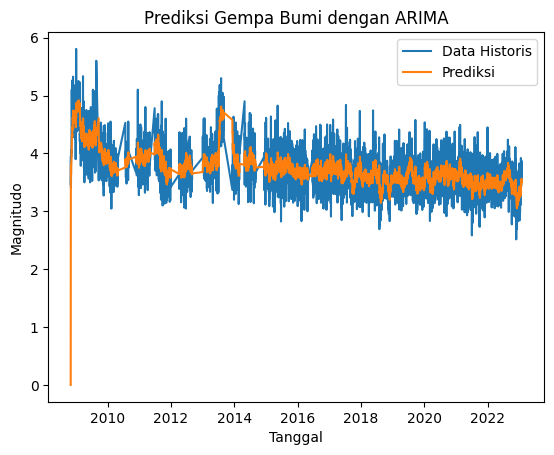

In [43]:
# Mengubah tipe data kolom tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

# Define the ARIMA order
order = (1, 1, 1)

# Perform Time Series Cross-validation
tscv = TimeSeriesSplit(n_splits=10)
rmse_scores = []

for train_index, test_index in tscv.split(df['Magnitudo']):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Fit the ARIMA model
    model = ARIMA(train['Magnitudo'], order=order)
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test['Magnitudo'], predictions))
    rmse_scores.append(rmse)

# Calculate the average RMSE
avg_rmse = np.mean(rmse_scores)

# Print the average RMSE
print("Average RMSE:", avg_rmse)

# Fit the ARIMA model using the entire data
model = ARIMA(df['Magnitudo'], order=order)
model_fit = model.fit()

# Make predictions for the entire data
forecast_values = model_fit.predict(start=df.index[0], end=df.index[-1])

# Plot the results
plt.plot(df['Tanggal'], df['Magnitudo'], label='Data Historis')
plt.plot(df['Tanggal'], forecast_values, label='Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Magnitudo')
plt.title('Prediksi Gempa Bumi dengan ARIMA')
plt.legend()
plt.show()

# **# EVALUATION**

Terdapat beberapa Metrix Evaluasi dalam proses analisis Time Series dalam kasus kali ini kami menggunakan metrix evaluasi RMSE.

Metrik evaluasi RMSE (Root Mean Square Error) adalah salah satu metrik yang umum digunakan dalam analisis dan pemodelan, terutama dalam konteks prediksi atau ramalan. RMSE digunakan untuk mengukur seberapa akurat model prediksi dalam memprediksi nilai-nilai yang sebenarnya dalam dataset.

Cara perhitungan RMSE adalah sebagai berikut:

1. Hitung selisih antara nilai prediksi (ŷ) dengan nilai sebenarnya (y) untuk setiap observasi dalam dataset.
2. Kuadratkan selisih masing-masing prediksi dan sebenarnya.
3. Hitung rata-rata dari kuadrat selisih di atas (Mean Squared Error, MSE).
4. Ambil akar kuadrat dari rata-rata kuadrat selisih untuk mendapatkan RMSE.

Rumus matematika untuk RMSE adalah:

$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

di mana:
- \( n \) adalah jumlah observasi dalam dataset.
- \( y_i \) adalah nilai sebenarnya pada observasi ke-i.
- \( y_i \) adalah nilai prediksi pada observasi ke-i.

RMSE memberikan gambaran tentang seberapa dekat nilai prediksi model dengan nilai sebenarnya. Semakin kecil nilai RMSE, semakin baik performa model dalam meramalkan nilai-nilai yang sebenarnya. RMSE juga berguna dalam membandingkan kinerja beberapa model yang berbeda; model dengan RMSE yang lebih kecil lebih diinginkan karena lebih mendekati nilai sebenarnya.